### 数据引入

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.io import mmread
import pandas as pd
import numpy as np
import os

In [2]:
geneA_path = "/mnt/storage/user/rotation/scGE/pbmc10k/filtered_feature_bc_matrix"
geneB_path = "/mnt/storage/user/rotation/scGE/Breast_Cancer/filtered_feature_bc_matrix"

In [3]:
geneA = pd.read_csv(os.path.join(geneA_path, "features.tsv"), header=None, sep="\t")
geneB = pd.read_csv(os.path.join(geneB_path, "features.tsv"), header=None, sep="\t")

In [4]:
features = np.array(geneA.iloc[:, 1])

In [5]:
# 读取细胞标记
barcodeA = pd.read_csv(os.path.join(geneA_path, "barcodes.tsv"), header=None, sep="\t")
barcodeB = pd.read_csv(os.path.join(geneB_path, "barcodes.tsv"), header=None, sep="\t")

In [6]:
# 读取表达矩阵
mtxA = mmread(os.path.join(geneA_path, "matrix.mtx")).todense()
mtxB = mmread(os.path.join(geneB_path, "matrix.mtx")).todense()

In [7]:
# 转换DataFrame
mtxA = pd.DataFrame(mtxA, index=features, columns=barcodeA.iloc[:, 0]).T
mtxB = pd.DataFrame(mtxB, index=features, columns=barcodeB.iloc[:, 0]).T
# 合并表达矩阵矩阵
mtx = pd.concat([mtxA, mtxB], axis=0).fillna(0).astype(int)
print(mtxA.shape, mtxB.shape, mtx.shape)

(11984, 36601) (5680, 36601) (17664, 36601)


### 降维

#### t-SNE

In [22]:
from sklearn.manifold import TSNE

In [23]:
mtx_embedded = TSNE(n_components=2).fit_transform(mtx)

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


#### TruncatedSVD

In [9]:
from sklearn.decomposition import TruncatedSVD

In [10]:
mtx_embedded = TruncatedSVD(n_components=2).fit_transform(mtx)

In [25]:
mtx_embedded.shape[0] == barcodeA.shape[0] + barcodeB.shape[0]

True

### 数据预测

In [34]:
from sklearn.model_selection import train_test_split

In [81]:
labels = np.zeros(mtx_embedded.shape[0], dtype=int)
labels[barcodeA.shape[0]:] = 1
X_train, X_test, y_train, y_test = train_test_split(np.arange(mtx.shape[0]), labels, test_size=0.2, random_state=0)

#### KMeans

In [26]:
from sklearn.cluster import KMeans

In [28]:
cluster_kmeans = KMeans(n_clusters=2)
cluster_kmeans.fit(mtx_embedded[X_train, :])
print(cluster_kmeans.labels_)

/home/xintianle/miniconda3/envs/atac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 0 0 ... 0 0 0]


In [29]:
# 分类准确率
labels_predict = cluster_kmeans.predict(mtx_embedded[X_test, :])
np.sum(labels_predict == labels[X_test]) / len(labels_predict)
labels_predict = cluster_kmeans.predict(mtx_embedded)

0.6943107840362298

#### SVM

In [32]:
from sklearn import svm

In [70]:
mdoel = svm.SVC().fit(np.array(mtx)[X_train, :], labels[X_train])
labels_predict = mdoel.predict(np.array(mtx)[X_test, :])
print(np.sum(labels_predict == labels[X_test]) / len(labels_predict))

0.9898103594678743


In [71]:
labels_predict = mdoel.predict(mtx.iloc[X_test, :])

/home/xintianle/miniconda3/envs/atac/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


#### 决策树

#### 神经网络

### 可视化

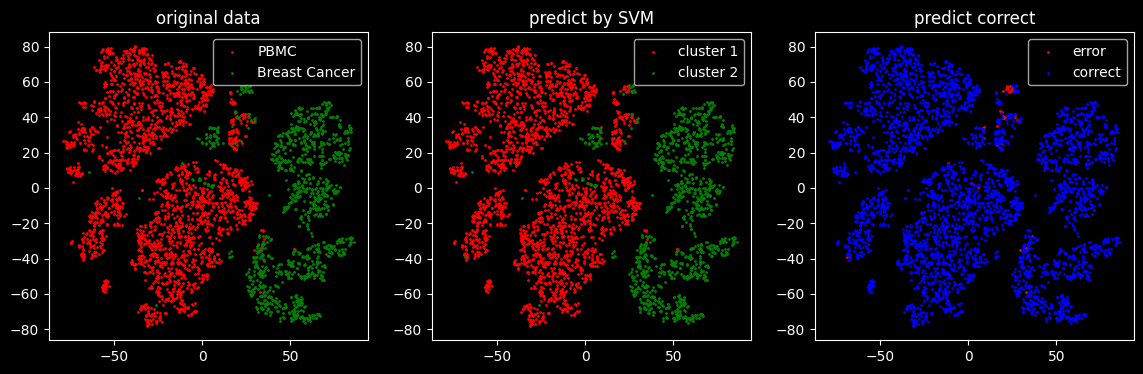

In [80]:
plt.figure(figsize=(14, 4))
# 原始数据分布图
plt.subplot(1, 3, 1)
plt.scatter(mtx_embedded[X_test, :][X_test < barcodeA.shape[0], 0], mtx_embedded[X_test, :][X_test < barcodeA.shape[0], 1], 1, color='red', label='PBMC')
plt.scatter(mtx_embedded[X_test, :][X_test >= barcodeA.shape[0], 0], mtx_embedded[X_test, :][X_test >= barcodeA.shape[0], 1], 1, color='green', label='Breast Cancer')
plt.legend(loc='upper right')
plt.title('original data')
# 聚类分布图
plt.subplot(1, 3, 2)
plt.scatter(mtx_embedded[X_test, :][labels_predict == 0, 0], mtx_embedded[X_test, :][labels_predict == 0, 1], 1, color='red', label='cluster 1')
plt.scatter(mtx_embedded[X_test, :][labels_predict == 1, 0], mtx_embedded[X_test, :][labels_predict == 1, 1], 1, color='green', label='cluster 2')
plt.legend(loc='upper right')
plt.title('predict by SVM')
# 预测分布图
plt.subplot(1, 3, 3)
plt.scatter(mtx_embedded[X_test, :][labels_predict != labels[X_test], 0], mtx_embedded[X_test, :][labels_predict != labels[X_test], 1], 1, color='RED', label='error')
plt.scatter(mtx_embedded[X_test, :][labels_predict == labels[X_test], 0], mtx_embedded[X_test, :][labels_predict == labels[X_test], 1], 1, color='blue', label='correct')
plt.legend(loc='upper right')
plt.title('predict correct')
plt.show()

In [38]:
# DataFrame转换为稀疏矩阵
from scipy.sparse import csr_matrix
dicT = csr_matrix(dicT.values)
print(dicT)

  (0, 0)	1
  (0, 2)	1
  (1, 1)	1
  (2, 1)	1
  (2, 2)	1
  (3, 2)	1
  (3, 3)	1
  (4, 4)	1


### 